<a href="https://colab.research.google.com/github/jmarrietar/mineria-de-datos/blob/main/%5BProyecto%5D%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Mineria de Datos - Clustering 

#### Aplicar mínimo tres algoritmos de agrupación y comparar los tres modelos con medidas internas y/o externas

# Data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
import plotly.express as px
import plotly.io as pio
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(11,10)})

In [2]:
!gdown https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS

Downloading...
From: https://drive.google.com/uc?id=1_AJd_FiQ6LSWSK4e__ccfLzhu_sWWNUS
To: /content/OnlineRetail.csv
45.6MB [00:00, 88.4MB/s]


In [3]:
online_retail = pd.read_csv(
    "OnlineRetail.csv",
    sep=",",
    dtype={"CustomerID": "object"},
    encoding="unicode_escape",
)

In [4]:
def cluster_metrics(X, labels, metric="cosine"):
    """Calculate Silhoutte & Davies Bouldin score"""

    X2 = X.copy()
    X2["cluster"] = labels
    X2["silhouette_sample"] = metrics.silhouette_samples(X, labels, metric=metric)

    print(
        "Silhoutte score: {:.3f}".format(
            metrics.silhouette_score(X, labels, metric=metric)
        )
    )
    print("Intra Cluster Silhoutte score:")
    print(X2.groupby("cluster")["silhouette_sample"].mean())
    print(
        "Davies Bouldin score: {:.3f}".format(metrics.davies_bouldin_score(X, labels))
    )

# Pre-procesamiento

In [5]:
# Create a new column for the total expenditure of that product in the purchase.
online_retail["total_sales_amount"] = (
    online_retail["UnitPrice"] * online_retail["Quantity"]
)

# Add column for cancelations 
online_retail['cancelation'] = online_retail['InvoiceNo'].apply(lambda x: x.startswith("C"))
online_retail['cancelation'] = online_retail['total_sales_amount'] <0

# Only positive purchases (No cancelations)
online_retail_purchases = online_retail[online_retail['cancelation'] == False] 

In [6]:
customers_purchases = (
    online_retail_purchases.groupby(["CustomerID"])[["Quantity", "total_sales_amount"]]
    .agg("sum")
    .reset_index()
)

Se utilizaran para el clustering las columnas `Quantity` como la cantidad total de items el usuario ha comprado y `total_sales_amount` como la cantidad total gastada por ese usuario. 

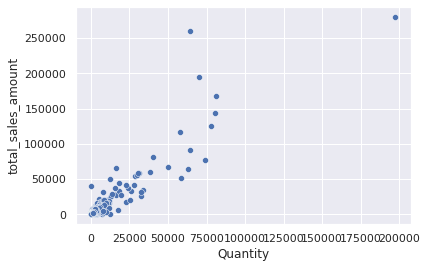

In [7]:
sns.scatterplot(data=customers_purchases, x="Quantity", y="total_sales_amount")

Crear nuevas columnas con los diferentes formas de scalamiento 

In [8]:
# Normalize
customers_purchases["Quantity_norm"] = preprocessing.normalize(customers_purchases["Quantity"].values.reshape(-1,1), norm='l2', axis=0)
customers_purchases["total_sales_amount_norm"] = preprocessing.normalize(customers_purchases["total_sales_amount"].values.reshape(-1,1), norm='l2', axis=0)

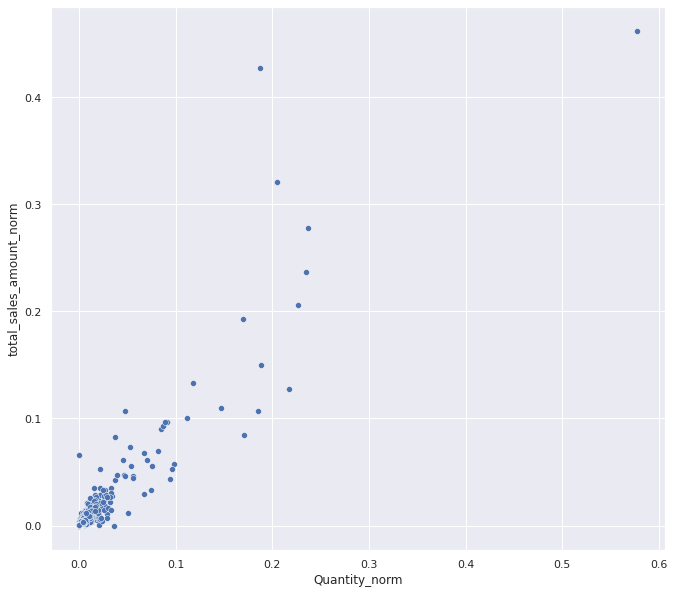

In [13]:
sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm")

# K-means

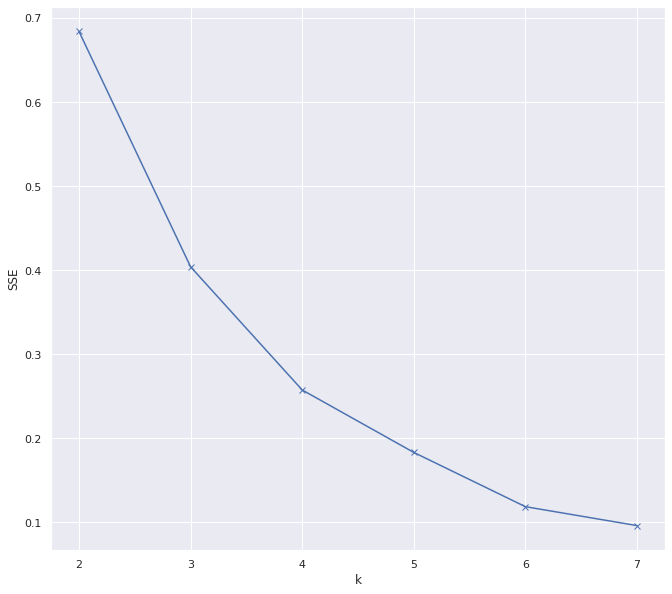

In [14]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

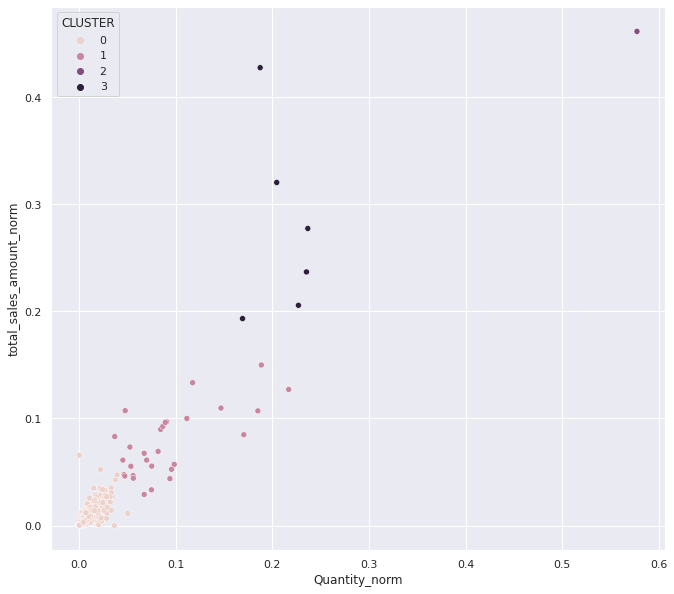

In [81]:
# Create clusters
N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = kmeans.labels_

sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

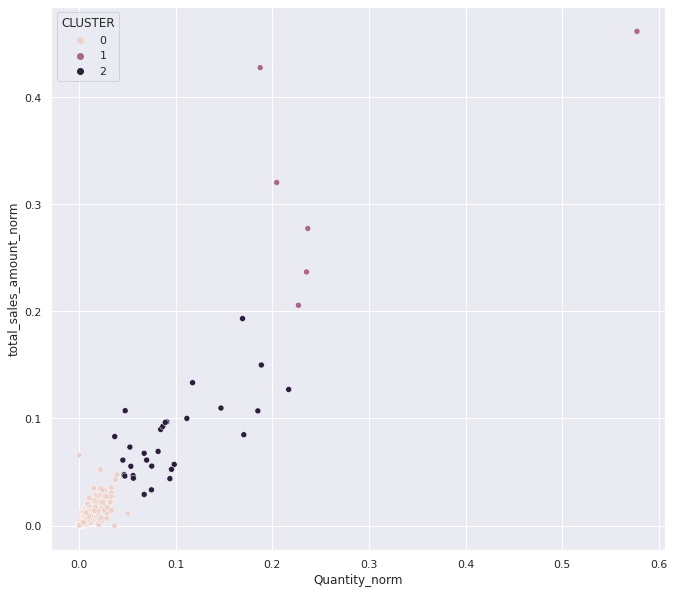

In [15]:
# Create clusters
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = kmeans.labels_

sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

### K-means 2

In [18]:
customers_purchases_level_0 = customers_purchases[customers_purchases['CLUSTER'] == 0]

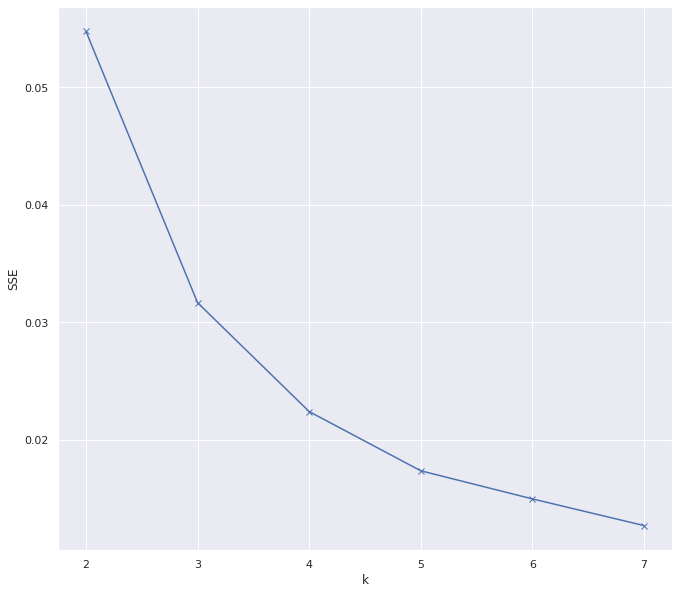

In [19]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(customers_purchases_level_0[["Quantity_norm", "total_sales_amount_norm"]])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



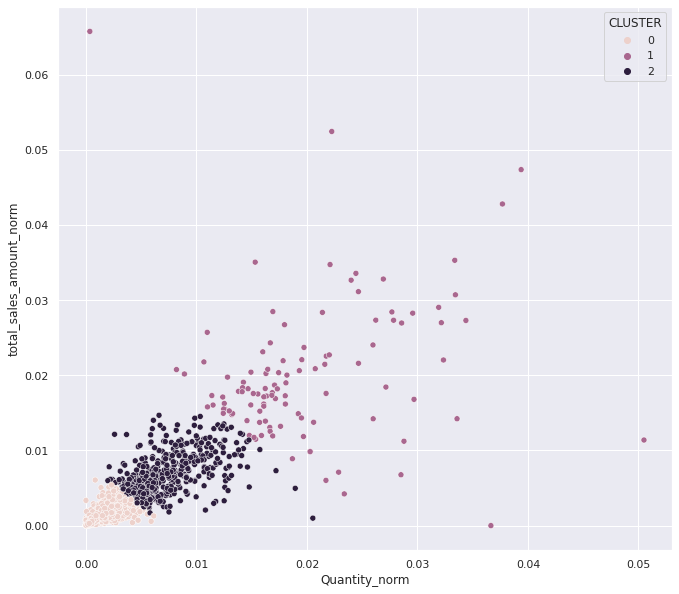

In [29]:
# Create clusters
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(customers_purchases_level_0[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases_level_0['CLUSTER'] = kmeans.labels_

sns.color_palette("rocket_r", as_cmap=True)

sns.scatterplot(data=customers_purchases_level_0, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER", cmap="crest")

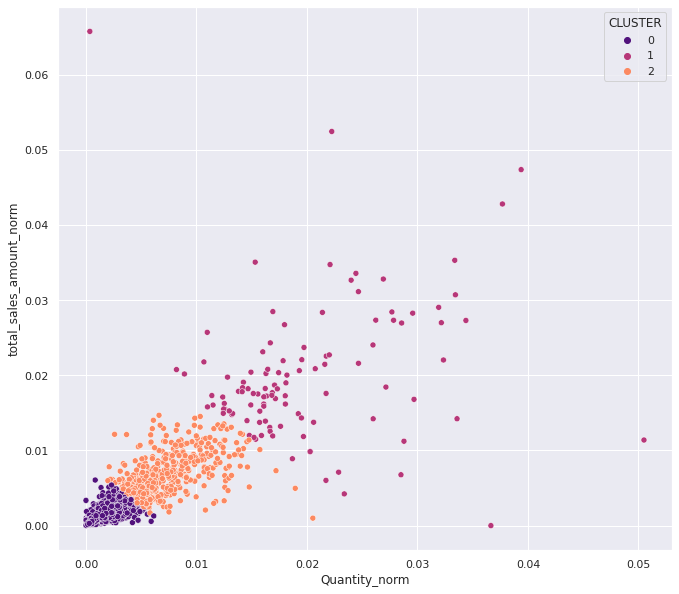

In [37]:
sns.scatterplot(data=customers_purchases_level_0, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER", palette=sns.color_palette('magma', n_colors=3))

In [21]:
len(customers_purchases_level_0)

4303

In [22]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3541],
       [   1,  109],
       [   2,  653]])

In [23]:
cluster_metrics(customers_purchases_level_0[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases_level_0['CLUSTER'], metric="euclidean")

Silhoutte score: 0.706
Intra Cluster Silhoutte score:
cluster
0    0.778939
1    0.290287
2    0.381494
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.635


----

In [83]:
(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 4303],
       [   1,    6],
       [   2,   30]])

In [ ]:
X = customers_purchases[["Quantity_norm", "total_sales_amount_norm"]]
X2 = customers_purchases[["Quantity_norm", "total_sales_amount_norm"]]
labels = kmeans.labels_
X2["cluster"] = kmeans.labels_
X2["silhouette_sample"] = metrics.silhouette_samples(X, labels, metric="euclidean")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X2["silhouette_sample"].mean()

0.9572414930729433

In [ ]:


    print(
        "Silhoutte score: {:.3f}".format(
            metrics.silhouette_score(X, labels, metric=metric)
        )
    )
    print("Intra Cluster Silhoutte score:")
    print(X2.groupby("cluster")["silhouette_sample"].mean())
    print(
        "Davies Bouldin score: {:.3f}".format(metrics.davies_bouldin_score(X, labels))
    )

In [ ]:
cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.957
Intra Cluster Silhoutte score:
cluster
0    0.962357
1    0.319567
2    0.351113
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.566


In [ ]:
(0.962357+0.319567+0.351113)/3

0.5443456666666667

# DBSCAN

In [84]:
clustering = DBSCAN(eps=0.05, min_samples=2, metric="euclidean").fit(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])

# Assign cluster
customers_purchases['CLUSTER'] = clustering.labels_

In [85]:
(unique, counts) = np.unique(clustering.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  -1,    3],
       [   0, 4333],
       [   1,    3]])

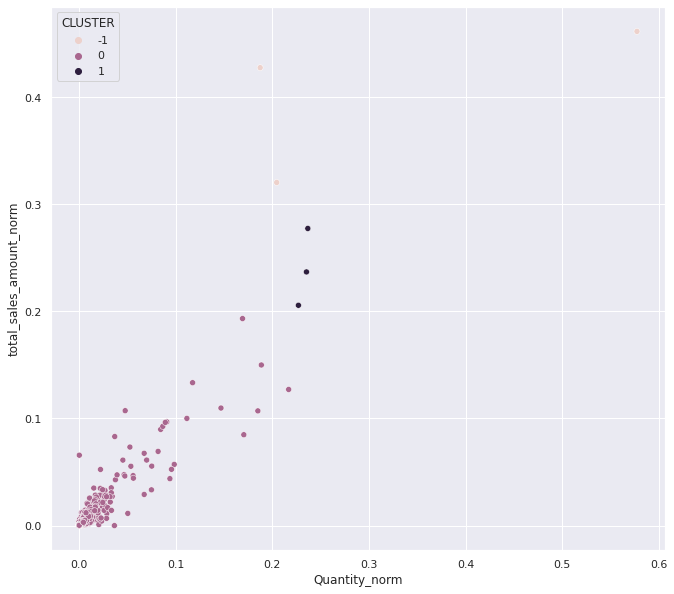

In [19]:
sns.scatterplot(data=customers_purchases, x="Quantity_norm", y="total_sales_amount_norm", hue="CLUSTER")

In [ ]:
cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.979
Intra Cluster Silhoutte score:
cluster
-1   -0.282777
 0    0.979817
 1    0.785789
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.859


# Jerarquico

#### Single

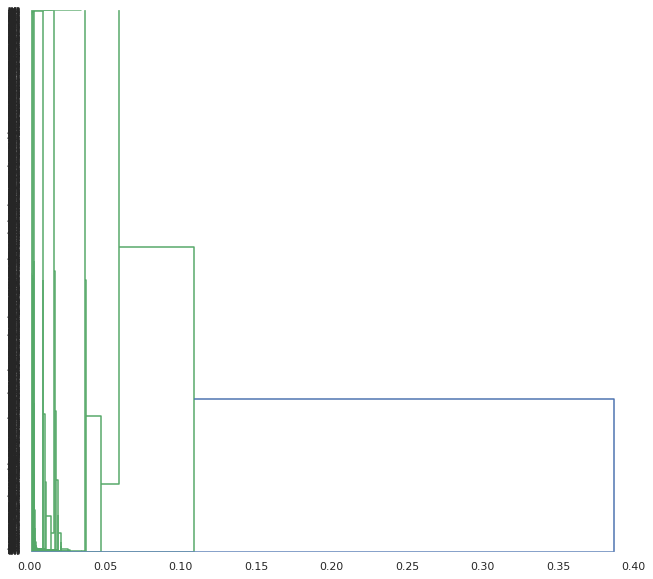

In [21]:
Z = hierarchy.single(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [63]:
max_d = 0.05
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [64]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

In [53]:
# Assign cluster
customers_purchases['CLUSTER'] = clusters

cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.979
Intra Cluster Silhoutte score:
cluster
1    0.979817
2    0.364261
3    0.000000
4    0.000000
5    0.000000
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.176


#### Average

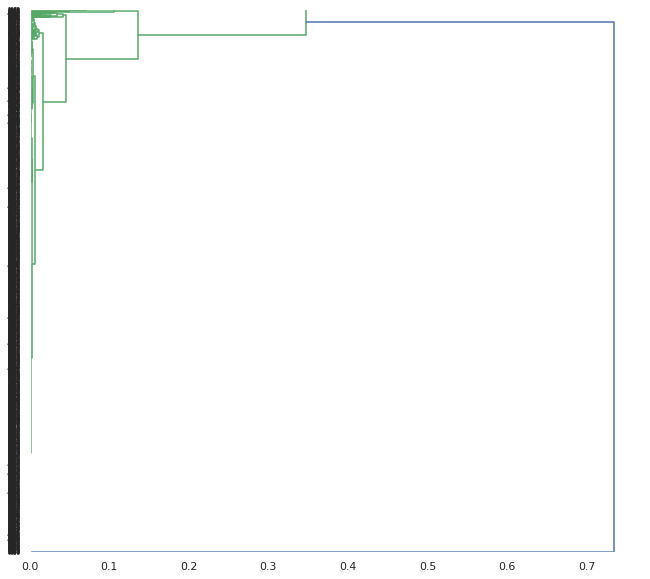

In [73]:
Z = hierarchy.average(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [79]:
max_d = 0.1
clusters = fcluster(Z, max_d, criterion='distance')
clusters

# Assign cluster
customers_purchases['CLUSTER'] = clusters

cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.950
Intra Cluster Silhoutte score:
cluster
1    0.953588
2    0.598390
3    0.402860
4    0.287575
5    0.000000
6    0.000000
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.423


In [80]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   1, 4311],
       [   2,   15],
       [   3,    6],
       [   4,    5],
       [   5,    1],
       [   6,    1]])

#### Ward

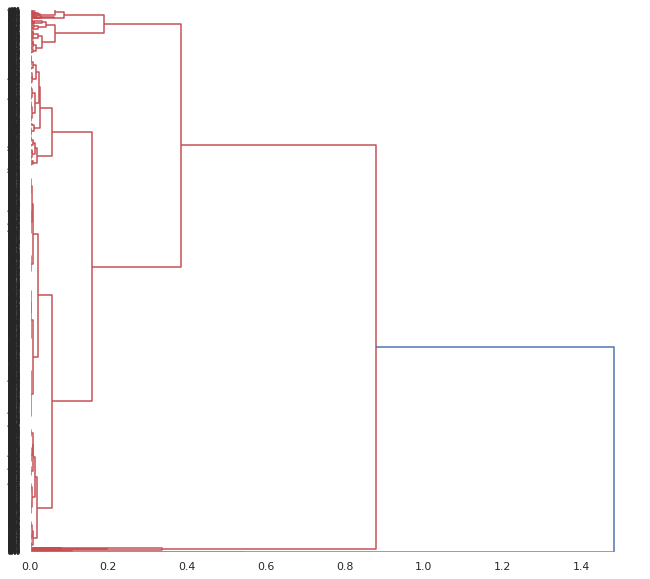

In [ ]:
Z = hierarchy.ward(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [ ]:
max_d = 0.6
clusters = fcluster(Z, max_d, criterion='distance')
clusters

# Assign cluster
customers_purchases['CLUSTER'] = clusters

cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.955
Intra Cluster Silhoutte score:
cluster
1    0.287593
2    0.358357
3    0.959960
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.563


In [ ]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

#### Complete

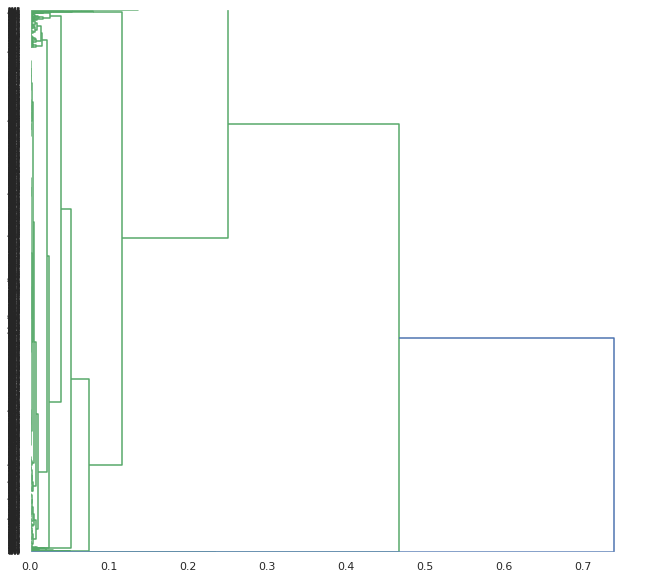

In [66]:
Z = hierarchy.complete(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]])
dn = hierarchy.dendrogram(Z, orientation='right')

In [70]:
max_d = 0.2
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 3, 3, ..., 3, 3, 3], dtype=int32)

In [71]:
(unique, counts) = np.unique(clusters, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   1,    5],
       [   2,    1],
       [   3, 4321],
       [   4,   11],
       [   5,    1]])

In [72]:
# Assign cluster
customers_purchases['CLUSTER'] = clusters

cluster_metrics(customers_purchases[["Quantity_norm", "total_sales_amount_norm"]], customers_purchases['CLUSTER'], metric="euclidean")

Silhoutte score: 0.965
Intra Cluster Silhoutte score:
cluster
1    0.371892
2    0.000000
3    0.967762
4    0.512672
5    0.000000
Name: silhouette_sample, dtype: float64
Davies Bouldin score: 0.377
